# Aperture Photometry - Tutorials

Notebook documenting the learning process for apeture photometry using https://photutils.readthedocs.io/en/stable/aperture.html

In [1]:
from photutils import CircularAperture
positions = [(30.,30.), (40.,40.)]
aperture = CircularAperture(positions, r=3.)

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture

positions = SkyCoord(l=[1.2,2.3] * u.deg, b=[0.1,0.2] * u.deg, frame = 'galactic')
aperture = SkyCircularAperture(positions, r=4. * u.arcsec)

The aperture object has now been created and so photometry can now be performed in the code below. This is done by defining an aperture at a certain position which is done in the first box but repeated here.

In [3]:
positions = [(30.,30.), (40.,40.)]
aperture = CircularAperture(positions, r=3.)

In [4]:
import numpy as np
from photutils import aperture_photometry

data = np.ones((100,100))
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0    28.274334
  2    40.0    40.0    28.274334


In [5]:
print(np.pi * 3. ** 2)

28.274333882308138


Here the overlap of the aperture with the data pixels is considered.

In [6]:
phot_table = aperture_photometry(data, aperture, method='subpixel', subpixels=5)
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0        27.96
  2    40.0    40.0        27.96


The aperture_photometry() function assumes that background subtraction has been done to the data. Local background subtraction can be completed using an annulus aperture surrounding each source, this is done by defining a mean background level by performing photometry in an annulus aperture.

An example of a simple mean within a circular annulus is completed below:

In [8]:
from photutils import CircularAnnulus

positions = [(30.,30.), (40.,40.)]
aperture = CircularAperture(positions, r=3.)
annulus_aperture = CircularAnnulus(positions, r_in=6., r_out=8.)

# then perform photometry in both apertures:

In [9]:
apers = [aperture, annulus_aperture] # both apertures
phot_table = aperture_photometry(data, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1      30      30      28.274334      87.964594
  2      40      40      28.274334      87.964594


Due to each aperture having different areas, a simple subtraction does not work here. The mean local background can be calculated by dividing its sum by its area by using the area() atribute.

In [10]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

The total background in the circular aperture is the mean local background times the circular aperture.

In [11]:
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'
print(phot_table['residual_aperture_sum'])

residual_aperture_sum
---------------------
       -7.1054274e-15
       -7.1054274e-15


As all data values are 1.0, the residual aperture sum here should be zero.

Another method is the sigma-clipped median

(130, 250)

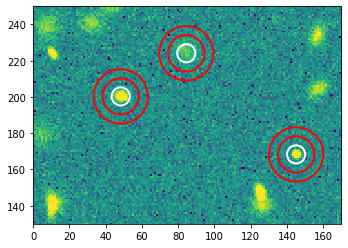

In [15]:
from photutils.datasets import make_100gaussians_image
from photutils import CircularAperture, CircularAnnulus
data = make_100gaussians_image()
positions = [(145.1,168.3),(84.5,224.1),(48.3,200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

#plot
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest')
aperture.plot(color='white', lw=2)
annulus_aperture.plot(color='red', lw=2)
plt.xlim(0,170)
plt.ylim(130,250)

In [16]:
annulus_masks = annulus_aperture.to_mask(method='center')

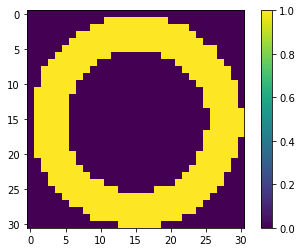

In [17]:
plt.imshow(annulus_masks[0], interpolation='nearest')
plt.colorbar()

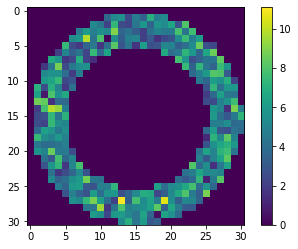

In [18]:
annulus_data = annulus_masks[0].multiply(data)
plt.imshow(annulus_data)
plt.colorbar()

In [19]:
mask = annulus_masks[0].data
annulus_data_1d = annulus_data[mask > 0]
annulus_data_1d.shape

(394,)

In [20]:
from astropy.stats import sigma_clipped_stats
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
print(median_sigclip)

4.848212997882959


In [21]:
#total background within the circular aperture is now the local background level times the aperture area
background = median_sigclip * aperture.area
print(background)

380.7777584296913


In [23]:
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry
from photutils import CircularAperture, CircularAnnulus
from photutils.datasets import make_100gaussians_image

data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
annulus_masks = annulus_aperture.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, aperture)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * aperture.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot)

 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                                                        
--- ------- ------- ------------ -------------- --------- ---------------
  1   145.1   168.3    1131.5794       4.848213 380.77776       750.80166
  2    84.5   224.1    746.16064      5.0884354 399.64478       346.51586
  3    48.3   200.3    1250.2186      4.8060599 377.46706        872.7515


## Error estimation

Suppose a previously calculated error on each pixel's value has been saved in an array $\text{error}$:

In [24]:
error = 0.1 * data

phot_table = aperture_photometry(data, aperture, error=error)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1   145.1   168.3    1131.5794        20.481206
  2    84.5   224.1    746.16064        8.6551786
  3    48.3   200.3    1250.2186        17.388092


## Aperture photometry using sky coordinates

This is an example of photometry on real world data using a SkyCircularAperture. Load in a Spitzer 4.5 micron image:

In [25]:
import astropy.units as u
from astropy.wcs import WCS
from photutils import datasets

# loading dataset
hdu = datasets.load_spitzer_image()
data = u.Quantity(hdu.data, unit=hdu.header['BUNIT'])
wcs = WCS(hdu.header)
catalog = datasets.load_spitzer_catalog()

In [26]:
# setting up apertures
positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')
aperture = SkyCircularAperture(positions, r=4.8 * u.arcsec)
phot_table = aperture_photometry(data, aperture, wcs=wcs)

# convert to correct units
factor = (1.2 * u.arcsec) ** 2 / u.pixel
fluxes_catalog = catalog['f4_5']
converted_aperture_sum = (phot_table['aperture_sum'] * factor).to(u.mJy / u.pixel)

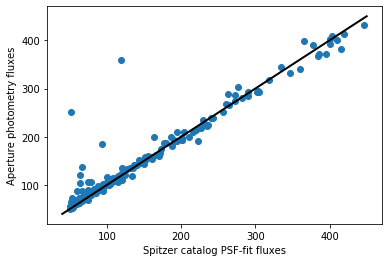

In [29]:
plt.scatter(fluxes_catalog, converted_aperture_sum.value)
plt.xlabel('Spitzer catalog PSF-fit fluxes')
plt.ylabel('Aperture photometry fluxes')
plt.plot([40, 100, 450],[40, 100, 450], color='black', lw=2)